# Cats and Dog Classifier
This notebook is to play around with transfer learning and build a dog/cat classifier on top of an existing NN model.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image

## Load in data with torch. Important notes
- Test/train split can be done with `random_split` from `torch.utils.data`
- Use `torchvision.transforms` to apply image transforms to data. We can apply after splitting data.

In [2]:
# Function to check if the image is corrupted. Maybe this is too slow....
def is_image_valid(filename):
    try:
        img = Image.open(filename)  # Try opening the image
        img.verify()  # Verify if the image is valid
        return True
    except:
        return False

import sys
data_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'

# Define transform 
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Crop test data to match input to existing NN.
test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Create dataset with ImageFolder
dataset = datasets.ImageFolder(root=data_dir, 
                               transform=None, # Transform will be applied later
                               is_valid_file=is_image_valid # Pass in callback.
                              )  

# Perform train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Apply transformations to train and test datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Create data loaders for train and test datasets
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Create dictionary which maps label ints to class names.

In [3]:
label_dict = dict(zip(range(len(dataset.classes)),dataset.classes))
print(label_dict)

{0: 'Cat', 1: 'Dog'}


## Visualize the transformed images.

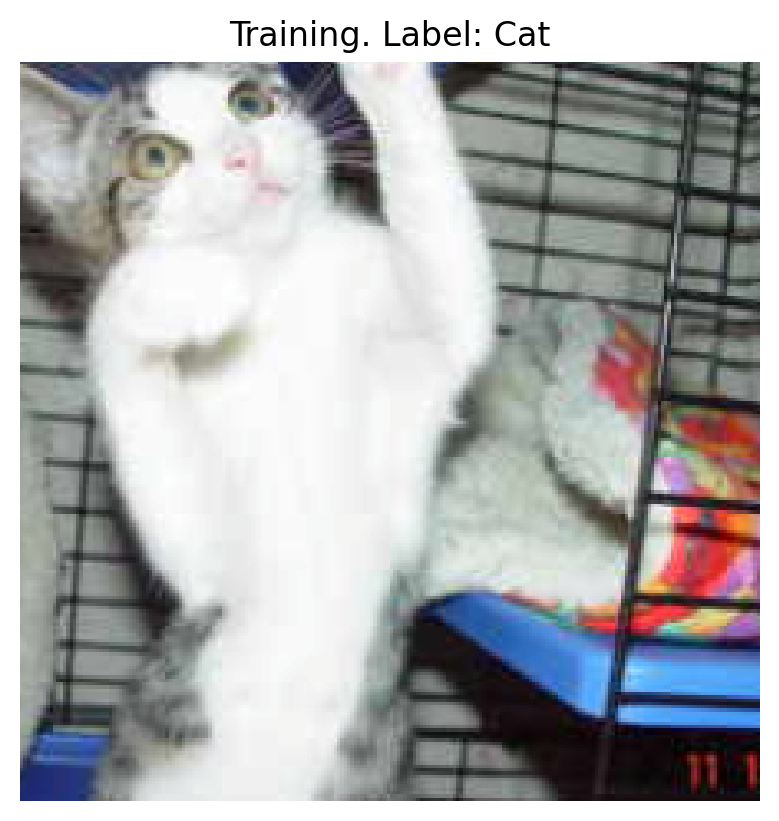

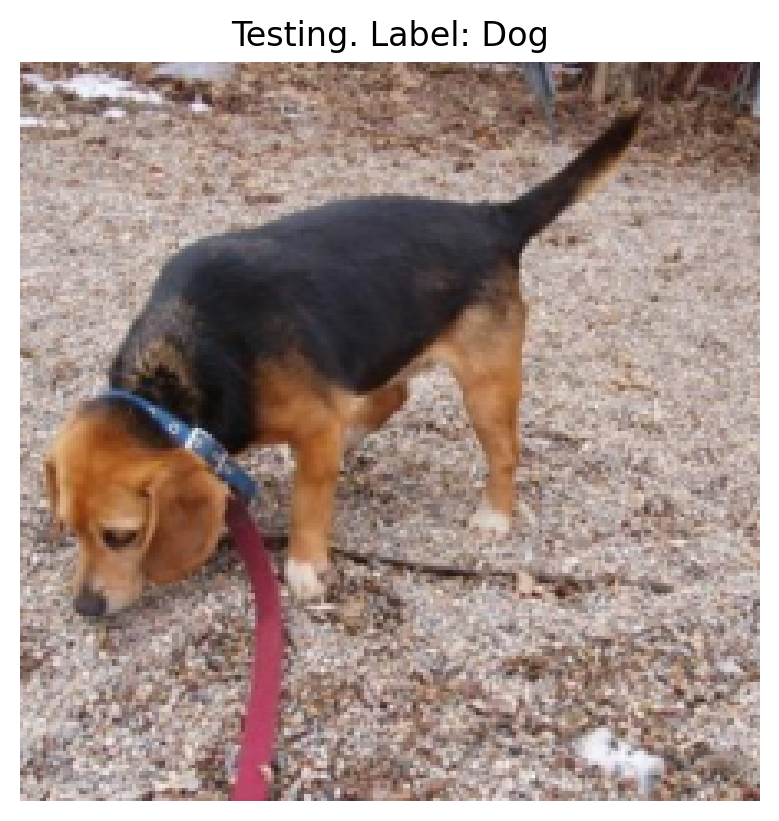

In [4]:
def tensor_imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
train_images, train_labels = next(iter(train_loader))
ax_train = tensor_imshow(train_images[0])
ax_train.set_title('Training. Label: {}'.format(label_dict[train_labels[0].item()]))

test_images, test_labels = next(iter(test_loader))
ax_test = tensor_imshow(test_images[0])
ax_test.set_title('Testing. Label: {}'.format(label_dict[test_labels[0].item()]))
plt.show()

## Import densenet to use transfer learning.

In [5]:
model = models.densenet121(weights=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 73.4MB/s]


## Setup for optimization. Define NN classifier layer.
Define classifier layer to swap out with densenet's classification. Classifier layer in densenet has input of 1024 and output of 1000. We can create 2 fully connected layers of 256 with ReLU and then output to 2 classes with LogSoftmax. Specify dropout for regularization.

In [6]:
# Pull in cuda if it is availble.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != 'cuda':
    print("Not using GPU. Training will be slow. Toggle in the top right corner to use GPU.")
else:
    print("Using GPU.")

# Parameter freezing is important here since we don't want to modify existing weights. Just want to backprop our new classification layers.
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(1024, 256),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(256, 2),
                           nn.LogSoftmax(dim=1)
                          )
model.classifier = classifier

# Use negative log likelihood since we have output layer of LogSoftmax.
criterion = nn.NLLLoss()

# Only train the parameters of the classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Move to the GPU
model.to(device);

Using GPU.


## Train classifier layer of model using Adam optimization
Note: I used a simple method to introduce an early exit out of the optimization since training took a long time with no real gain at some point. The method takes a look at the training loss, averaged over `print_skip` number of batches, and if it doesn't decrease for `loss_not_decreasing_count_breakout` number of times, then the optimization exits.

In [7]:
epochs = 1
steps = 0
running_loss = 0
print_skip = 5

train_loss_list = []
test_loss_list = []

# Create breakout mechanism to end training early if we have converged.
prev_loss = float('inf')
loss_not_decreasing_count_breakout = 3
loss_not_decreasing_count = 0

for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logp = model.forward(inputs)
        loss = criterion(logp, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_skip == 0:
            test_loss = 0
            accuracy = 0
            # Switch model to evaluation mode so we don't use dropout.
            model.eval()
            # Don't use gradients when computing test evaluation.
            with torch.no_grad():
                for inputs, labels in test_loader:
                    # Move test tensors to device.
                    inputs, labels = inputs.to(device), labels.to(device)
                    logp = model.forward(inputs)
                    batch_loss = criterion(logp, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    prob = torch.exp(logp)
                    top_prob, top_class = prob.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            train_loss = running_loss/print_skip
            test_loss = test_loss/len(test_loader)
            test_accuracy = accuracy/len(test_loader)
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {test_accuracy:.3f}")
            # Update loss lists.
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            
            if(prev_loss <= train_loss):
                loss_not_decreasing_count += 1
                print("Loss didn't decrease {} times".format(loss_not_decreasing_count))
            if loss_not_decreasing_count >= loss_not_decreasing_count_breakout:
                break
            prev_loss = train_loss
        
            running_loss = 0
            # Switch the model back to train mode so we use dropout.
            model.train()
    if loss_not_decreasing_count >= loss_not_decreasing_count_breakout:
        print("Ending optimization early due to loss not decreasing: {} times".format(loss_not_decreasing_count))
        break

Epoch 1/1.. Train loss: 0.391.. Test loss: 0.124.. Test accuracy: 0.976
Epoch 1/1.. Train loss: 0.117.. Test loss: 0.067.. Test accuracy: 0.977
Epoch 1/1.. Train loss: 0.076.. Test loss: 0.093.. Test accuracy: 0.965
Epoch 1/1.. Train loss: 0.101.. Test loss: 0.087.. Test accuracy: 0.968
Loss didn't decrease 1 times
Epoch 1/1.. Train loss: 0.072.. Test loss: 0.049.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.059.. Test loss: 0.048.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.074.. Test loss: 0.048.. Test accuracy: 0.982
Loss didn't decrease 2 times
Epoch 1/1.. Train loss: 0.056.. Test loss: 0.052.. Test accuracy: 0.981
Epoch 1/1.. Train loss: 0.054.. Test loss: 0.065.. Test accuracy: 0.978
Epoch 1/1.. Train loss: 0.037.. Test loss: 0.062.. Test accuracy: 0.976
Epoch 1/1.. Train loss: 0.066.. Test loss: 0.044.. Test accuracy: 0.985
Loss didn't decrease 3 times
Ending optimization early due to loss not decreasing: 3 times


## Plot loss over iterations.

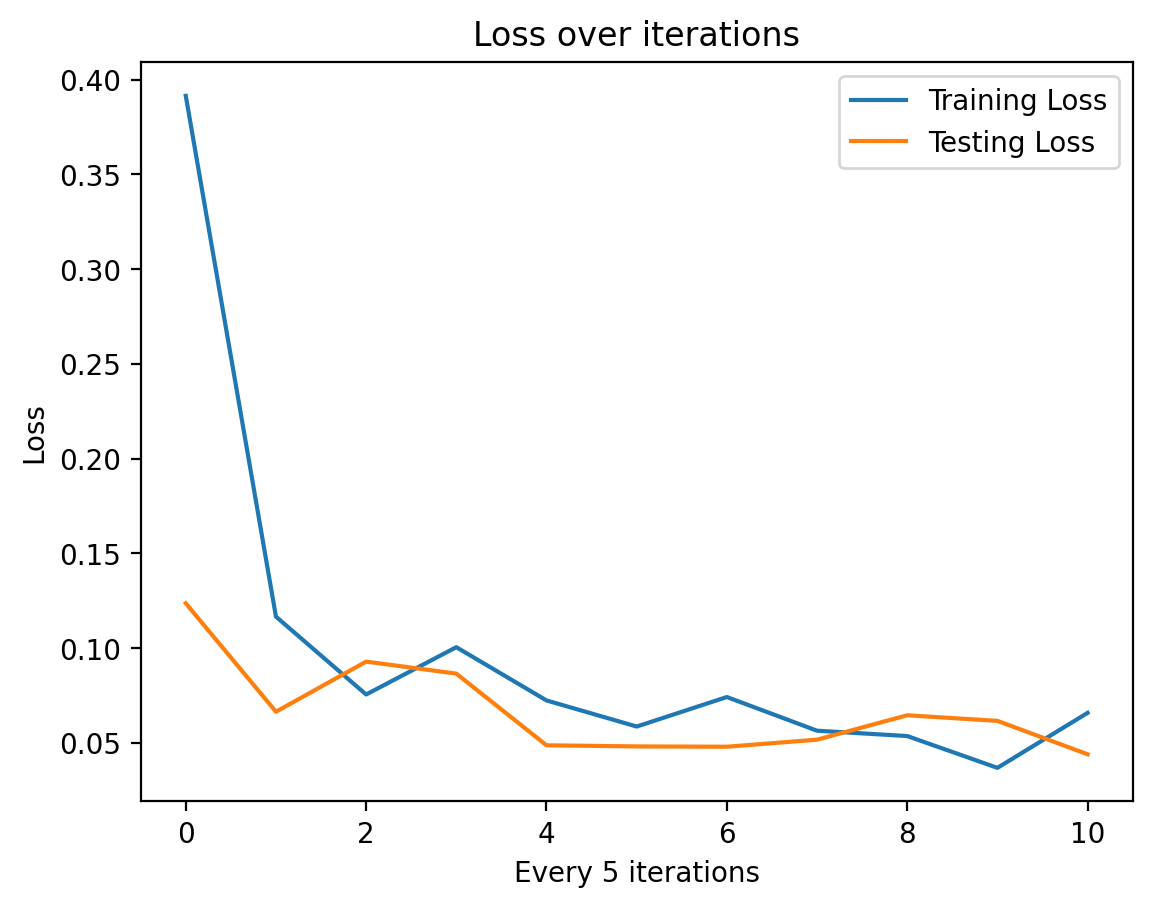

In [8]:
plt.plot(train_loss_list,label='Training Loss')
plt.plot(test_loss_list, label = 'Testing Loss')
plt.title("Loss over iterations")
plt.xlabel("Every {} iterations".format(print_skip))
plt.ylabel("Loss")
plt.legend()
plt.show()

## Validate with random test images.

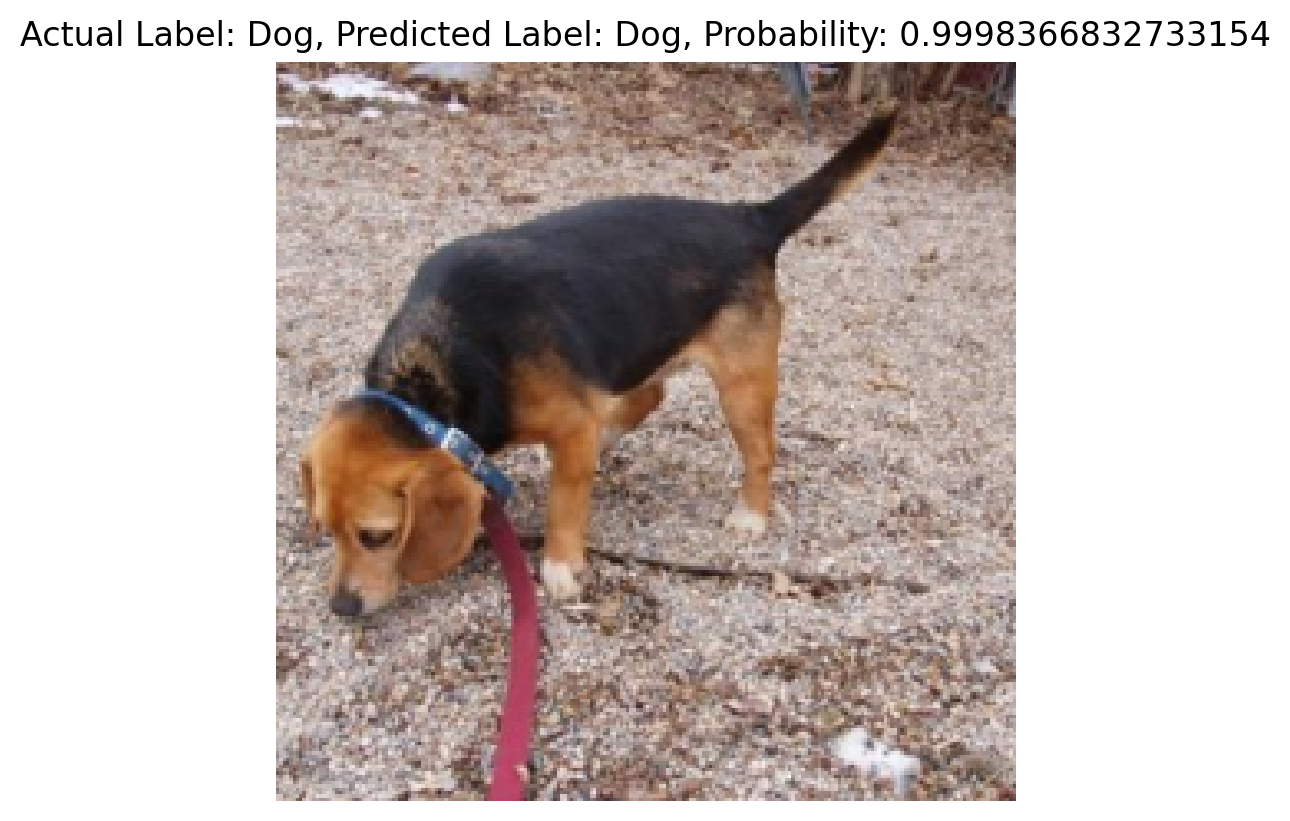

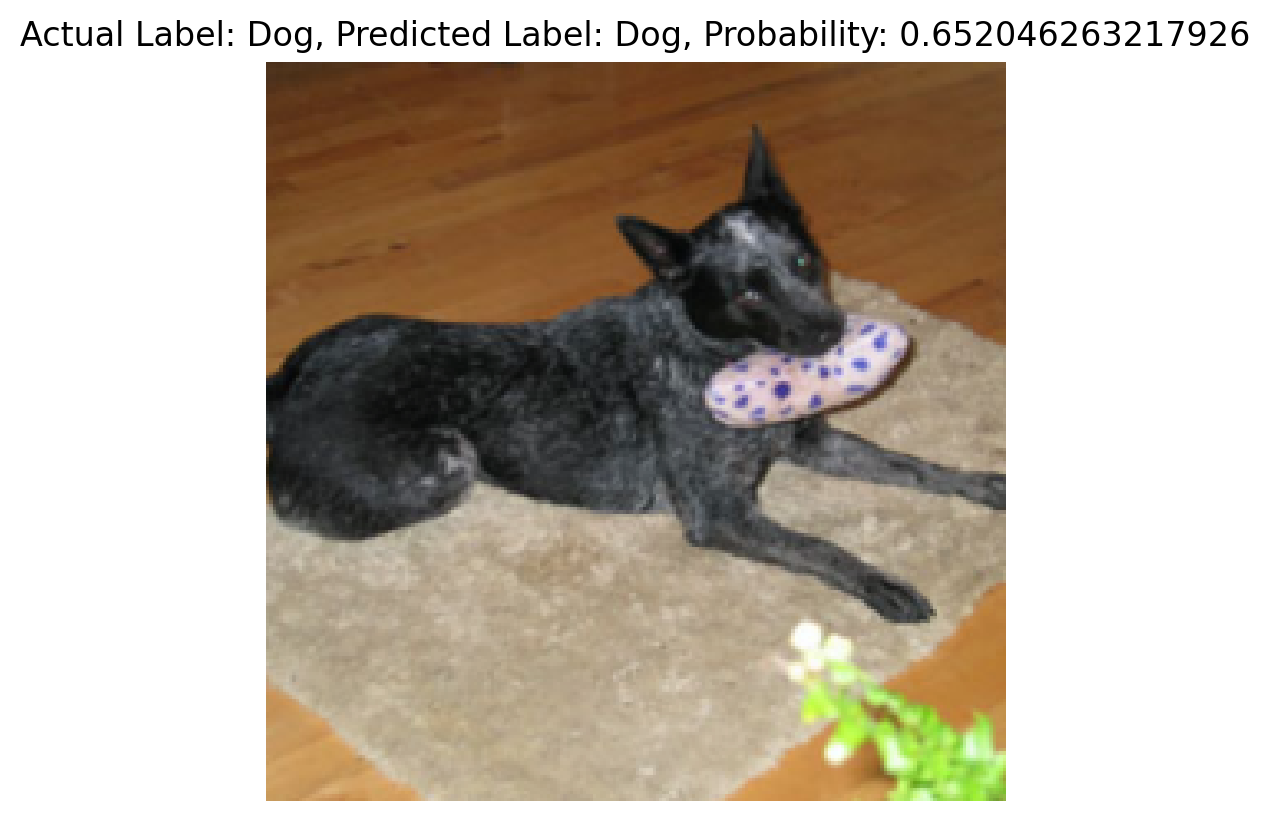

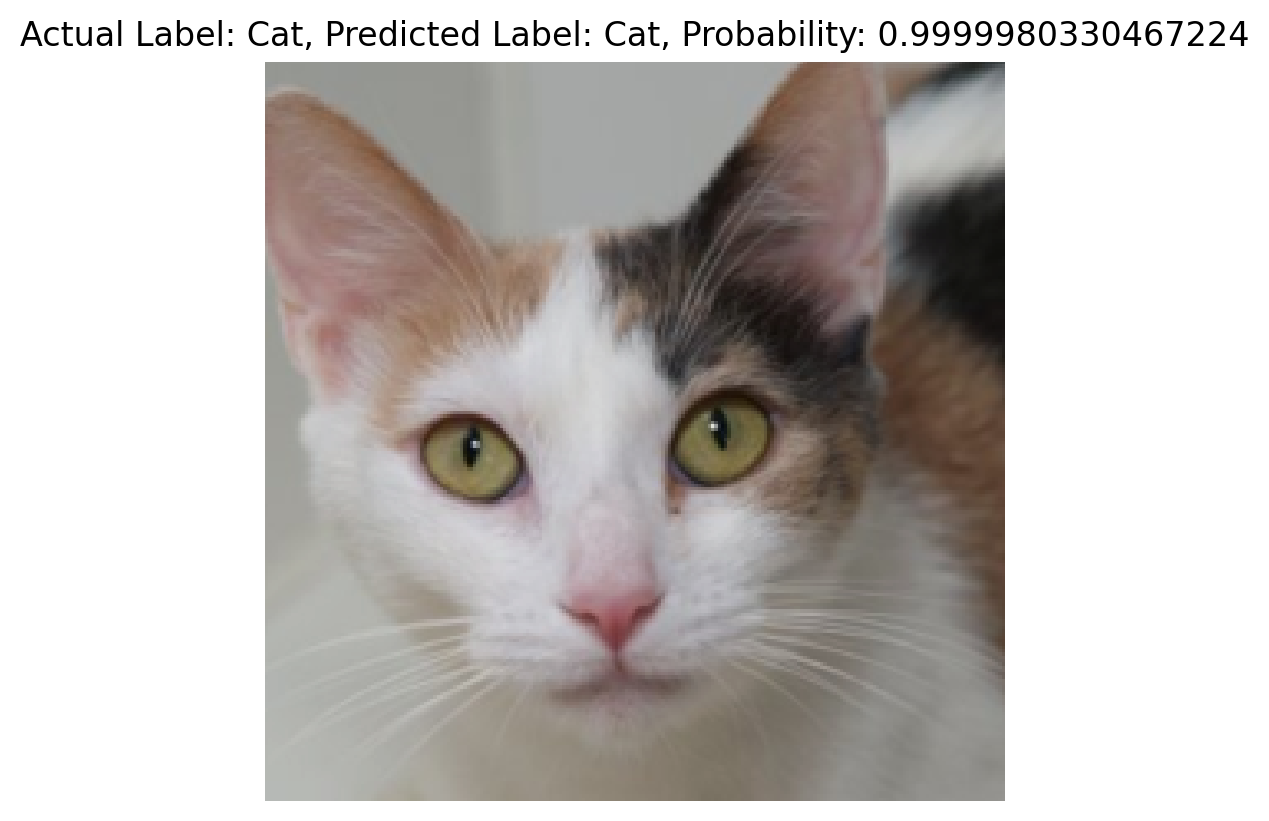

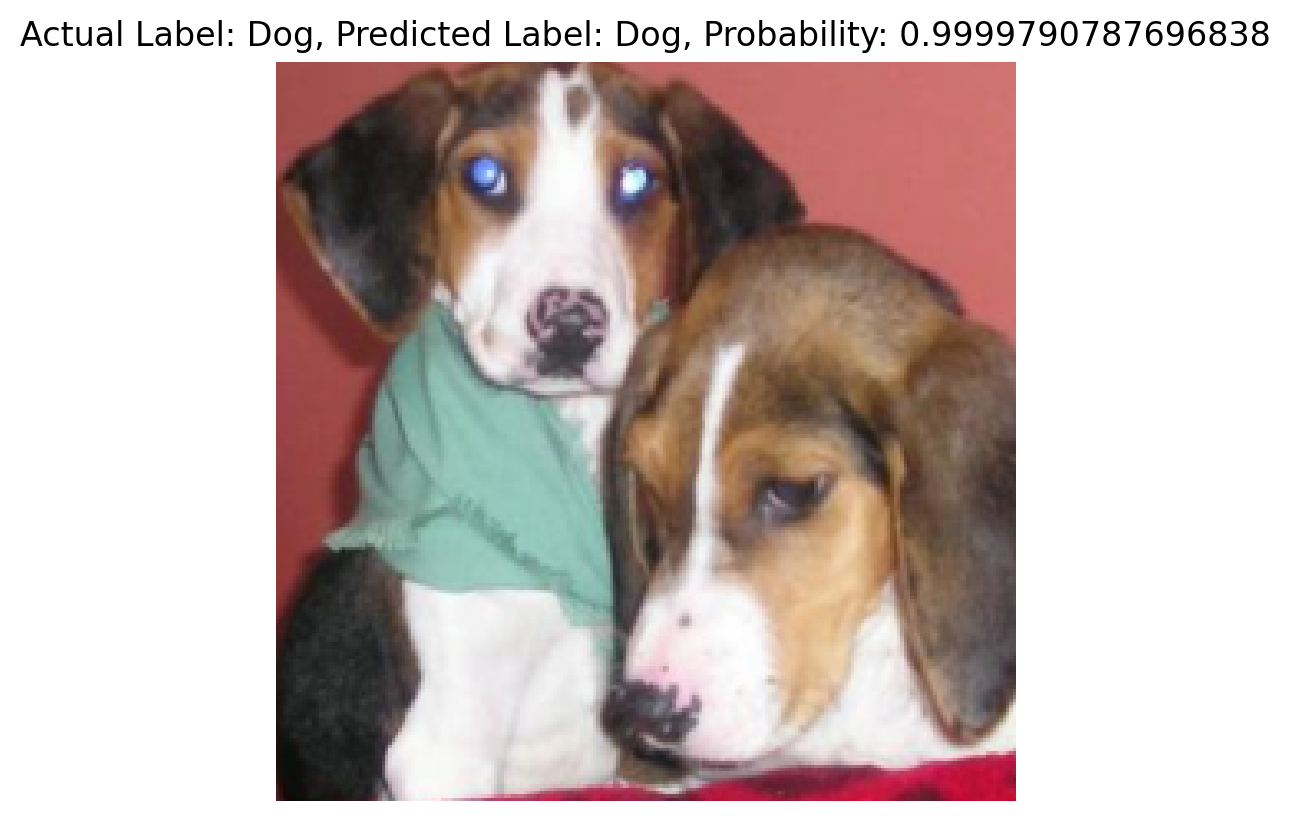

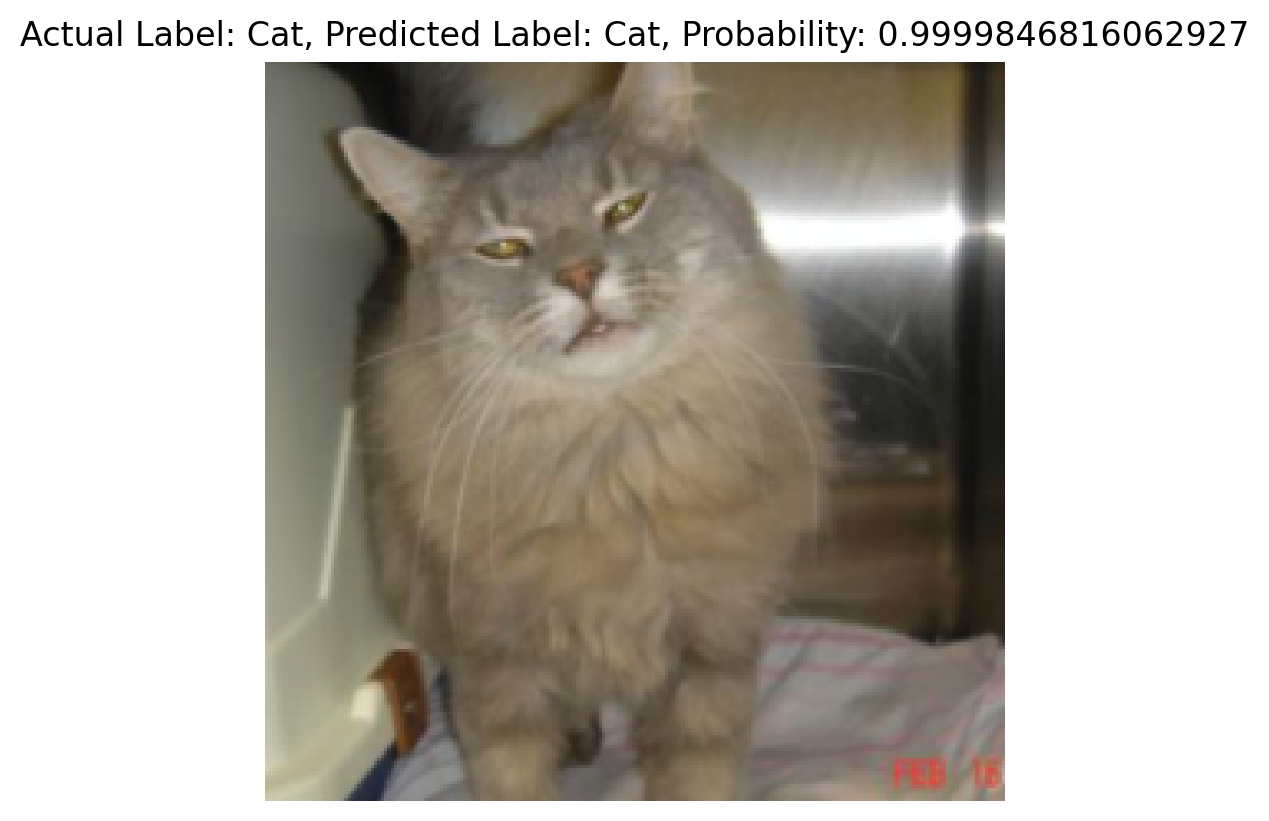

In [9]:
# Get a test image
view_n_images = 5

# Switch model to eval and don't compute gradient.
model.eval()
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    # Move tensors to GPU.
    test_images_device, test_labels_device = test_images.to(device), test_labels.to(device)
    # Predict for entire set of test images.
    logp = model.forward(test_images_device)
    prob = torch.exp(logp)
    top_prob, top_classes = prob.topk(1, dim=1)
    
    for test_idx in range(view_n_images):
        ax_test = tensor_imshow(test_images[test_idx,:,:,:])
        predicted_label = label_dict[top_classes[test_idx].item()]
        predicted_probability = top_prob[test_idx].item()
        actual_label = label_dict[test_labels[test_idx].item()]
        
        ax_test.set_title('Actual Label: {}, Predicted Label: {}, Probability: {}'.format(actual_label,predicted_label,predicted_probability))
plt.show()